In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import time
import seaborn as sns
from submapp import *
from tools.tools_som import *
from submapp.tools.data_processing import *
from submapp.tools.evaluation import *



## STEP 0: data processing

##### 0.1 Extract data from files

There is nothing to change in this cell, just run the cell to extract data from the netcdf4 file. 
If this does not work, make sure the file ``GotmFabmErsem-BATS.nc`` is in the right folder. (It should be in the same folder as this notebook, ``submapp`` folder and ``tools`` folder )

In [2]:
############ STEP 0.1 ##################################################
# ---- Extracting data
([temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]) = data_extraction()
gotm_data = [temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]
data_type = ["temp", "sst", "dswr", "airt", "ws10", "depth"]

for i in range(len(gotm_data)-1):
    for y in range(len(gotm_data[i])):
        gotm_data[i][y] = mean_steps(gotm_data[i][y],10)
[temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth] = gotm_data

##### 0.2 Select data types

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Select the data types you want to work with by initializing the list ``data_type_used`` with some of the following elements 
     - 0: Temperature (temp)
     - 1: Sea surface temperature (sst)
     - 2: Incoming Short Wave Radiation (dswr)
     - 3: Air Temperature (airt)
     - 4: Wind Speed (ws10)
     - (-1): Depth (depth)
     
``Temperature (0)`` is related to the vertical profiles of temperature, in our case they are the "*hidden*" values.

`` Depth (-1)`` is a vector of levels of depth corresponding to the vertical profiles

``Sea surface temperature (1), Incoming Short Wave Radiation (2), Air Temperature (3)`` and ``Wind Speed (4)`` are surface information types. in our case they are the "*observable*" values from which we want to infer *hidden* values

<span style="background-color: ##FFFF00">**NOTE**: </span>

- If you want to work with *hidden* variables then you should only select ``temperature`` then ``data_type_used = [0]``. 
- If you want to work with *observale* variables you are not forced to choose all the observable variables! Actually you should NOT use them all as some of them are highly correlated! In our case we will only use ``sst`` and ``dswr`` but feel free to play with other variables as well! :) 


In [3]:
############ STEP 0.2 ##################################################

# ----------------------------
# TODO: 
# --- Select your data by initializing data_type_used
# - 0: Temperature (temp)
# - 1: Sea surface temperature (sst)
# - 2: Incoming Short Wave Radiation (dswr)
# - 3: Air Temperature (airt)
# - 4: Wind Speed (ws10)
# - (-1): Depth (depth)
data_type_used = [1,2]  # suggested observable variables 
data_type_used = [0]  # hidden variables
# ----------------------------

##### 0.3 Split dataset

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Select the number of years in the training dataset (between ``0`` and ``16`` in our case). We suggest you choose ``12``

In [4]:
############ STEP 0.3 ##################################################

# ----------------------------
# TODO: 
# ---- Select the number of years in the training dataset (SUGGESTED 12)
nb_years_trained = 12
# ----------------------------


# Quick summary -- nothing to do here
print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
if 0 in data_type_used:
    surface=False
    data_y = [gotm_data[0]]
    nb_data_used = 1
    p = depth.size
else:
    surface=True
    nb_data_used = len(data_type_used)
    data_y = [gotm_data[i] for i in data_type_used]
    p = nb_data_used
    

print("DATA TYPE USED : ", [data_type[i] for i in data_type_used])
print("ARE DATA OBSERVABLE: ", surface)

nb_years = len(data_y[0])
print("SIZE OF INPUT VECTORS :", p)
print("NUMBER OF YEARS USED FOR TRAINING: ", nb_years_trained)
print("NUMBER OF YEARS USED FOR TESTING: ", nb_years-nb_years_trained)
print("TOTAL NUMBER OF YEARS: ", nb_years)

T_y=[]
for y in range(nb_years):
    T = len(data_y[0][y])
    T_y = np.concatenate([T_y, [T]])
    print("YEAR ", str(1992+y), " LENGTH : ", T )
T_y = T_y.astype(int)
print("LENGTH OF THE TRAINING TIME SERIES: ", sum(T_y[:nb_years_trained]))
print("LENGTH OF THE TESTING TIME SERIES: ", sum(T_y[nb_years_trained:]))
print("TOTAL LENGTH OF THE TIME SERIES : ", sum(T_y))

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
DATA TYPE USED :  ['temp']
ARE DATA OBSERVABLE:  False
SIZE OF INPUT VECTORS : 26
NUMBER OF YEARS USED FOR TRAINING:  12
NUMBER OF YEARS USED FOR TESTING:  4
TOTAL NUMBER OF YEARS:  16
YEAR  1992  LENGTH :  74
YEAR  1993  LENGTH :  73
YEAR  1994  LENGTH :  73
YEAR  1995  LENGTH :  73
YEAR  1996  LENGTH :  74
YEAR  1997  LENGTH :  73
YEAR  1998  LENGTH :  73
YEAR  1999  LENGTH :  73
YEAR  2000  LENGTH :  74
YEAR  2001  LENGTH :  73
YEAR  2002  LENGTH :  73
YEAR  2003  LENGTH :  73
YEAR  2004  LENGTH :  74
YEAR  2005  LENGTH :  73
YEAR  2006  LENGTH :  73
YEAR  2007  LENGTH :  72
LENGTH OF THE TRAINING TIME SERIES:  879
LENGTH OF THE TESTING TIME SERIES:  292
TOTAL LENGTH OF THE TIME SERIES :  1171


##### 0.3.bis [OPT] Emulate missing values

If you want to emulate missing values in your datasets you can specify a probability lower than 1 of getting an element for all instant of the time series.

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Specify ``prob``: define the probability ``p`` ( with ``0 <= p <= 1``) of getting a value for each instant ``t``

- Specify if this probability should be applied for the training phase set and/or the mapping phase:
    - ``complete_data_training = True`` if you want to use the complete dataset for the training phase
    - ``complete_data_mapping = False`` if you want to use the sparse dataset for the mapping phase

In [5]:
############ STEP 0.3.bis ###############################################
# ----------------------------
# TODO: 
# ---- Select the probability of getting data at each instant t
prob = 1.
# ----------------------------

# ----------------------------
# TODO: 
# ---- Select if the complete dataset should be used for training/mapping
# ---- Or only the sparse dataset
complete_data_training = True
complete_data_mapping = False
# ----------------------------

# --- Remove data randomly
complete_data = data_y

sparse_data = [[]]*nb_data_used
for dtype in range(nb_data_used):
    sparse_data[dtype] = [remove_random_data(data, prob=prob) for data in data_y[dtype]]

if complete_data_training:
    data_training = complete_data
else:
    data_training = sparse_data
if complete_data_mapping:
    data_mapping = complete_data
else:
    data_mapping = sparse_data

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")    

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------


##### 0.4 Standardization

There is nothing to do here, run the cell to standardize the data and have a quick summary about the original data

In [6]:
############ STEP 0.4 ###############################################

# --- Standardization: step 1: find standardization coeff (on the training data set only!)
data_training_tot = [np.concatenate(data[:nb_years_trained]) for data in data_training]
data_mean = np.zeros(nb_data_used)
data_stdev = np.zeros(nb_data_used)
data_max = np.zeros(nb_data_used)
data_min = np.zeros(nb_data_used)
for i in range(nb_data_used):
    data_max[i] = np.max(data_training_tot[i])
    data_min[i] = np.min(data_training_tot[i])
    (_ ,data_mean[i], data_stdev[i]) = standardize(data_training_tot[i])

# --- standardization: step 2: standardize
data_training_norm = [np.empty([]) for y in range(nb_years)]
data_mapping_norm = [np.empty([]) for y in range(nb_years)]
for y in range(nb_years):
    if len(data_y[0][0].shape) == 1:
        p_tmp=1
    else:
        (_,p_tmp) = data_y[0][0].shape
    data_training_norm[y] = np.concatenate([
        np.reshape(standardize(data_training[i][y], 
                  data_mean[i], 
                  data_stdev[i]),(T_y[y],p_tmp) ) for i in range(nb_data_used)], axis=1)
    data_mapping_norm[y] = np.concatenate([
        np.reshape(standardize(data_mapping[i][y], 
                  data_mean[i], 
                  data_stdev[i]),(T_y[y],p_tmp) ) for i in range(nb_data_used)], axis=1)
    
print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
for i in range(nb_data_used):
    print("DATA TYPE: ", 
          data_type[data_type_used[i]],
          " MEAN: ", round(data_mean[i],2),
          " STDEV: ", round(data_stdev[i],2),
          " MIN: ", round(data_min[i],2),
          " MAX: ", round(data_max[i],2))

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
DATA TYPE:  temp  MEAN:  22.84  STDEV:  2.81  MIN:  18.67  MAX:  30.17


## STEP 1: SOM configuration and evaluation

##### 1.1 Choose the shape of the SOM

__Shape (n, m)__

By *shape of the SOM* we mean here its number of row ``n`` and its number of column ``m``.

It is one of the most important parameters and we highly recommend you to test a lot of different shapes. To help you decide on the ratio ``m/n`` you can use the function ``pca_features`` whose first output is the ratio between the first 2 principal components. This ratio can be seen as a suggestion and the second output (the cumulative variance of the first 2 principal components) can be seen as an indicator of relevance of this suggestion. Once again, all this is only about "*suggestion*", "*indication*" and there is no garantee that this will give the best shape nor even a good one. Once again we highly recommend you to try different shapes!

__Total number of classes n*m__

The total number of classes ``nb_class=n*m`` matters as well. If this number is too low the SOM will poorly represent the diversity of the data. If this number is too high the SOM may overfit the training data and significantly loose accuracy when it comes to the testing dataset. This is a very commom problem in machine learning 
and there are tons of articles dealing with this issue. If you want to find out more about overfitting, how to detect it and prevent it check out [this article](https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42) by Julien Despois from which the 2 following figures are:
<figure>
<img src="img/overfitting01.png" alt="Recognize underfitting and overfitting" width="600" />
<figcaption> <center> Fig.1 - Recognize underfitting and overfitting </center> </figcaption>
<img src="img/overfitting02.png" alt="Overfitting and model complexity" width="500"/>
<figcaption> <center> Fig.2 - Overfitting and model complexity </center> </figcaption>
</figure>

However, in our context, both SOM we trained are to be combined with a HMM. In this situation, the bottom line is the accuracy of the prediction of hidden variables given observable variables and not the accuracy of the SOMs themselves. Another problem here is that the more classes there are, the more difficult it is to estimate the model parameters of the HMM, particularly the transition matrix ``Tr``. Thus even though the SOM are not overfitting the training dataset we may have to train new SOMs with fewer classes according to the output of the HMM. 

The accuracy of the hidden SOM is important though since it defines the best accuracy the HMM can reach. Indeed, in the ideal case your HMM estimates the best classses possible therefore the only error made is the difference between the *true value* and the referent vector representing this *true value*

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Specify ``n`` the number of rows and ``m`` the number of columns

In [7]:
############ STEP 1.1 ###############################################

#  Apply PCA on the training dataset. 
# - r: ratio between the first 2 principal components. 
# - c_v: cumulative variance of the first 2 principal components. 
r, c_v = pca_features(remove_nan(np.concatenate(data_training_norm[:nb_years_trained])))

# ----------------------------
# TODO:
# ---- Select the number of class and the shape of the SOM
# For instance (n,m) = (4,70) for hidden variables and (n,m) = (4,10) for observable variables
n = 4
m = 70
# ----------------------------

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
print("RATIO PC1/PC2: ", round(r,2), "\nCUMULATIVE VARIANCE: ", c_v)
print("SHAPE OF THE SOM :  (", n, "x", m, ")")
print("RATIO m/n:  ", round(m/n,2))
print("TOTAL NUMBER OF CLASSES: ", n*m)

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
RATIO PC1/PC2:  16.99 
CUMULATIVE VARIANCE:  0.9888303284989335
SHAPE OF THE SOM :  ( 4 x 70 )
RATIO m/n:   17.5
TOTAL NUMBER OF CLASSES:  280


##### 1.2 SOM initialization

###### 1.2.1 SOM name and path

If you want to save your ``Som`` object you should customize the name your ``Som`` object and the relative paths at which the objects have to be saved by default to make it easier to load them afterwards. 

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>

- Customize the name of the SOM
- Customize the default relative path at which the Som object will be saved
- Customize the default relative path at which the figures will be saved
- Customize the default relative path at which the Map2d object will be saved

In [8]:
############ STEP 1.2 ###############################################

############ STEP 1.2.1 ###############################################

# Retrieve the name of the data type used to customize the path
data_name = ""
for i in data_type_used:
    data_name = data_name + data_type[i] + "-" 
data_name=data_name[:-1]

# ----------------------------
# TODO: (Optional)
# ---- Customize the different default paths
path_fig = "figs/Map/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
path_som = "objects/Som/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
path_map = "objects/Map/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
# ----------------------------

# ----------------------------
# TODO: (Optional)
# ---- Customize the name of the Som object
name="1992-"+str(1992+nb_years_trained-1)+"_trained"
# ----------------------------

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
print("NAME OF THE SOM: ", name )
print("FIGS DIRECTORY: ",path_fig)
print("SOM DIRECTORY: ",path_som)
print("MAP DIRECTORY: ",path_map)

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
NAME OF THE SOM:  1992-2003_trained
FIGS DIRECTORY:  figs/Map/temp/4-70/100/
SOM DIRECTORY:  objects/Som/temp/4-70/100/
MAP DIRECTORY:  objects/Map/temp/4-70/100/


###### 1.2.2  SOM and weights initialization

Once the shape of the SOM is chosen, we can initialize our object ``mySom`` from the class ``Som``.

Then weights have to be initialized. The initialization may influence:
- The learning speed: how many iterations are necessary before getting good results
- The organization of the specialized aera within the SOM: where are the neurons representing the spring, the cool down, etc
- Performance at the end of the training

The learning rate and the radius of the neighborhood function can limit this influence. Indeed if both initial learning rate and radius are high, the very first inputs will re-organize the whole SOM almost independently of the initial state of the SOM. However a good initialization may ensure a stable and coherent internal structure of the SOM.


Weights can be initialized in many ways and none of them is better than all others so you can try different initialization processes. 

There are mainly 3 different approaches:
- Random initialization: each weight is a sample drawn from a distribution (Gaussian or a uniform for example)
- Sample initialization: each weight is a sample drawn from the training dataset
- Data analysis based initialization: each weight is spanned by eigenvectors of the input dataset or the referent vector of the K-means methods, etc.


Here you can use one of these methods
- ``random_weights_initialization``: Initializes weights randomly with a gaussian or uniform distribution
- ``pca_weights_initialization``: Initializes weights by applying a PCA on athe training dataset
- ``sample_weights_initialization``: Initializes weights with a sample of the training data
- ``zeros_weights_initialization``: Initializes all weights to zeros vectors

Otherwise you can specify your own weights when initializing the Som object

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Initialize the weights

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------


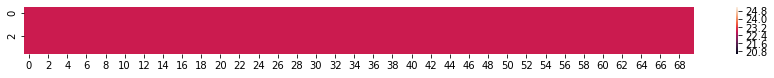

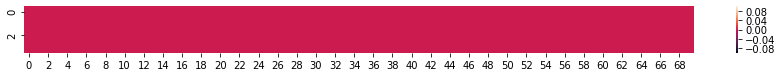

TEMPERATURE depth 0 - 6


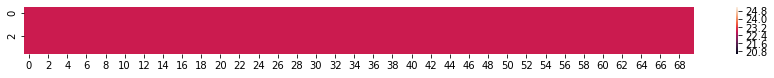

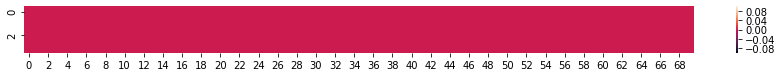

TEMPERATURE depth 6 - 13


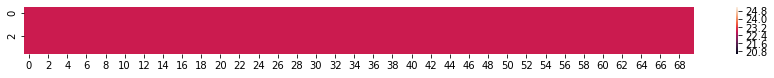

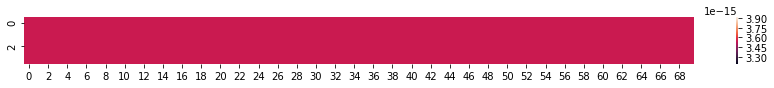

TEMPERATURE depth 13 - 19


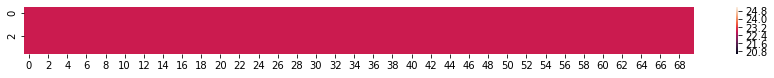

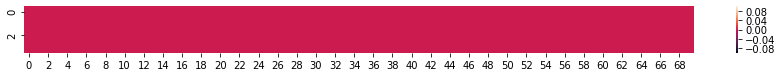

TEMPERATURE depth 19 - 26


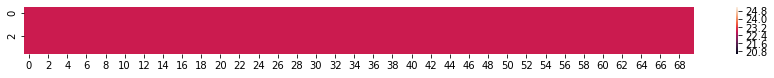

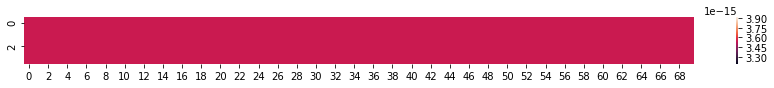

In [18]:
############ STEP 1.2.2 ###############################################

# Initialize the Som object 
mySom = som.Som(n,m,p,weights=None,name=name,data_mean=data_mean,data_stdev=data_stdev)

# ----------------------------
# TODO: (Optional)
# ---- Initialize the weights with one of these methods 
# ---- (or None of them but in that case specify your own weights when initializing the Som object)
mySom.random_weights_initialization(distribution="gaussian")
mySom.pca_weights_initialization(np.concatenate(data_training_norm[:nb_years_trained]))
mySom.sample_weights_initialization(np.concatenate(data_training_norm[:nb_years_trained]))
mySom.zeros_weights_initialization()
# ----------------------------


print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")

if not surface or p>1:
    # If we are using observable variable, each element of the vector represents a different type of data
    # and should be treated separately
    if surface:
        for i in range(nb_data_used):
            print("DATA TYPE : ", data_type[data_type_used[i]])
            weights_mean = mySom.weights_features(features="mean",start=i,end=i+1)
            mySom.print_heatmap(weights_mean)
    # If we are using hidden variable, each element of the vector represents a different level of depth 
    # of the temperature vertical profile and we can "merge" them to make the plotting easier to interpret 
    else:
        weights_mean = mySom.weights_features(features="mean")
        weights_dev = mySom.weights_features("std")
        mySom.print_heatmap(weights_mean)
        mySom.print_heatmap(weights_dev)
        parts = 4  # the whole profiles will be decomposed into 4 smaller profiles 
        for i in range(parts):
            start=i*p//parts
            end=(i+1)*p//parts
            print("TEMPERATURE depth", p-start, "-", p-end )
            weights_mean = mySom.weights_features(features="mean",start=start,end=end)
            mySom.print_heatmap(weights_mean)
            weights_std = mySom.weights_features(features="std",start=start,end=end)
            mySom.print_heatmap(weights_std)

##### 1.3 SOM training

Here a quick reminder about the training phase. 

```
1. Find the Best Matching Unit (BMU): class whose referent vector is the closest to the input
2. Update every referent vector: 
    1. compute the distance between the class associated with the referent vector and the BMU (in the map)
    2. update the referent vector so that the closer their associated class is to the BMU (in the map) the more their referent vector will be modified towards the input data.
```

Thus - for instance - for each instant $t$, given the input vector $x_t$ and knowing that the winning neuron is $c$ the weight $w_{i,j}$ is updated as follows:

$$w_{i,j} = w_{i,j} + \alpha \times h(w_{i,j},c) \times [w_{i,j}-x_t] $$

with:
$$ h(w_{i,j},c) = exp(\frac{dist(w_{i,j},c)}{ \sigma^{2} } )$$

$$ dist(w_{i_1,j_1},w_{i_2,j_2}) = ||i_1-i_2|| + ||j_1-j_2||$$

###### 1.3.1 Choose hyperparameters 

Before training our SOM we will have to choose (a lot of) hyperparameters. 
Here a quick description of some of them:

- **Learning rate** $\alpha$: ($0<\alpha<1$)

Determine the *rate* (or *speed*) of learning. 

If $\alpha$ is too high, the SOM won't be adaptative but will only reproduce its last training inputs. 

If $\alpha$ is too low, the SOM won't learn fast enough and the weights won't be representative enough of the data at the end of the training. 

The learning rate should decrease over the training. In our case $\alpha$ decreases linearly after each input vector from ``a0`` to ``aT`` after ``training_dataset_size`` inputs but it could have been a exponential decay of an inverse decay as well.

- **Radius** $\sigma$:  ($0<\sigma$)

Determine the $radius$ of the neighborhood function $h$. The neighborhood function determine how much neurons should learn around the *BMU* (Best Matching Unit: the neuron that was the closest to the input vector). 

If $\sigma$ is too high, too many neurons will be specialized (or activated) by a given input. As a consequence some neurons might get redundant and therefore useless while some features of the input data will be poorly represented.

If $\sigma$ is too low, the different areas will specialize too slowly. It could have different unwanted consequences: 
- Multiple small areas corresponding to similar data features instead of a bigger one
- Undertraining: some neurons are not trained enough because they are always too far from the *BMU* with respect to the radius.

The radius rate should decrease over the training. In our case $\sigma$ decreases linearly after each input vector from ``s0`` to ``sT`` after ``training_dataset_size`` inputs but it could have been a exponential decay of an inverse decay as well.


- **Epochs**:

Determine the number times that the entire training dataset will train the SOM. 

During the training phase or once the training is over, plots showing the error with respect to the epochs (sometimes called learning curves) can help to detect overfitting or underfitting. However if the learning rate and the radius decrease enough over the training and if the model is not too complex (total number of classes too high) there should not be overtraining due to a number of epochs too high. 

- **But also...**

There are more hyperparameters such as the distance function $dist(w_{i_1,j_1},w_{i_2,j_2})$ which determines whether the SOM is a rectangular or an hexagonal map for instance or the cost function that determines the meaning of "Best Matching Unit". However, they are beyond the scope of this tutorial and the idea behind the training remains the same. Here we use a rectangular map with the euclidean norm as a cost function.

###### 1.3.2 Train

Once all the hyperparameters are initialized we can start the training. 
To do so we use the method ``train`` that updates the weights of the SOM according to the formula above. We repeat the operation ``epochs`` times over the entire training dataset.

<span style="background-color: ##FFFF00">**TO DO**:</span>

- Initialize the number of epochs ``epochs``
- Initialize the hyperparameters ``(a0,aT,s0,sT)``
- Customize how the learning rate and the radius both decrease over the training

In [19]:
############ STEP 1.3 ###############################################

############ STEP 1.3.1 #############################################
# ----------------------------
# TODO:
# ---- Initialize hyperparameters
epochs = 20  # number of epochs
a0 = 0.9  # initial learning rate
aT = 0.5  # final learning rate (after the first epoch)
if surface:
    s0 = 4.  # initial radius (if observable variables)
    sT = 1  # final radius (if observable variables)
else:
    s0 = 4.  # initial radius (if hidden variables)
    sT = 1  # final radius (if hidden variables)
# ----------------------------

param = (a0,aT,s0,sT)
training_dataset_size = len(np.concatenate(data_training_norm[:nb_years_trained]))

############ STEP 1.3.2 #############################################
for e in range(epochs):
    print("#### Epoch : ", e, " ####")
    # A random year is selected from the learning dataset in order not to favor one year over another 
    for y in random.sample(range(nb_years_trained), nb_years_trained):
        # Train the SOM with one more year from the training dataset 
        inputs_array = data_training_norm[y]
        mySom.train(inputs_array, param=param, training_dataset_size=training_dataset_size)
        # Map the whole testing dataset to evaluate how the SOM has improved since the last training
        inputs_array = np.concatenate(data_mapping_norm[nb_years_trained:])
        mySom.map(inputs_array)
    # ----------------------------
    # TODO: 
    # ---- Hyperparameters can be updated after each epoch for a better control over the training
    a0=aT
    aT=max(aT/1.2,0.01)
    s0=sT
    sT=max(sT/1.2,0.5)
    # ----------------------------
    param = (a0,aT,s0,sT)

#### Epoch :  0  ####
Graph initialization
73  inputs trained in  0.1  sec
292  inputs mapped in  0.29  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.31  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.3  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.29  sec
74  inputs trained in  0.1  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.12  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.34  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.3  sec
74  inputs trained in  0.11  sec
292  inputs mapped in  0.29  sec
74  inputs trained in  0.11  sec
292  inputs mapped in  0.32  sec
#### Epoch :  1  ####
Graph initialization
74  inputs trained in  0.1  sec
292  inputs mapped in  0.29  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.31  se

292  inputs mapped in  0.33  sec
#### Epoch :  10  ####
Graph initialization
73  inputs trained in  0.1  sec
292  inputs mapped in  0.33  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.33  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.3  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.35  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.33  sec
73  inputs trained in  0.1  sec
292  inputs mapped in  0.35  sec
74  inputs trained in  0.11  sec
292  inputs mapped in  0.34  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.32  sec
74  inputs trained in  0.1  sec
292  inputs mapped in  0.32  sec
74  inputs trained in  0.1  sec
292  inputs mapped in  0.32  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.35  sec
#### Epoch :  11  ####
Graph initialization
74  inputs trained in  0.11  sec
292  inputs mapped in  0.34  sec
73  inputs trained in  0.11 

292  inputs mapped in  0.36  sec
73  inputs trained in  0.11  sec
292  inputs mapped in  0.38  sec


##### 1.4 SOM evaluation

Model evaluation corresponds to the question "Are results satisfying?". This is a very hard question and even more in our case in which we combine 2 machine learning methods. Indeed, we remind you that at the end the performance is determined by the estimation of hidden variables given observable variables and not by the output of the SOMs themselves.

Besides, one of the objectives of combining SOM and HMM is to use neighboring functions that propagate probabilities or penalize long transitions. However using these functions is relevant only if the internal structure of both SOM represent well the topology of the data. As a consequence in our situation, making sure that the of the different areas within the SOM are consistent is of paramount importance. Indeed, given a total number of classes, many different sets of parameters will train SOMs with similar accuracies but only few of them will have a consistent enough internal structure for applying neighborhood functions at the HMM stage. 



First we will try to ask more specific questions:
- Is there a problem of overfitting/underfitting?
- Is there a problem of overtraining/undertraining?
- Are similar weights close to each other - resulting in specialized areas in the map - as they should in a SOM?
- Are some neurons redundant?
- Are some areas used too often while some are never used for mapping?
- Are transitions between the BMU at instant ``t`` and ``t-1`` are mostly short/long?
- Is the standard deviation of the distance of transiton low/high?
- Are outputs of the SOM representative of the inputs?
- Are some periods of year well represented while some others are poorly represented?
- Can the SOM represent well enough extreme inputs (very high/low temperature? High on the surface and low in the deep subsurface? 

Now that the questions are more specific we can try to find some tools that may answer these questions.

###### 1.4.1 Learning curves

We have already mentioned learning curves while defining the hyperparameter ``epochs``. These curves show the error on both training and testing datasets with respect to the number of training iterations. Here are some cases and possible explanation: 

- The error starts to increase on the testing dataset while it is still decreasing on the training dataset: it is probably due to a problem of overfitting (model too complex? learning rate too high? training dataset not representative?)

- Both errors are still decreasing at the end of the training phase: it probably means that the model is undertrained (learning rate too low? epoch too low? radius too low?)

- Both errors are constant before the end of the training: The model has reached its optimum performance given its complexity before the specified number of epoch? The learning rate is so low that the updating phase has almost no impact on the weights?

- Training error should be lower than the testing one!

<span style="background-color: ##FFFF00">**TO DO**:</span>
- From now on there is nothing to do but interpreting plots and specifying whether objects and figures should be saved or not. But of course feel free to create new critera or plots! :)

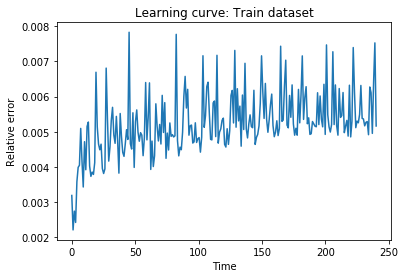

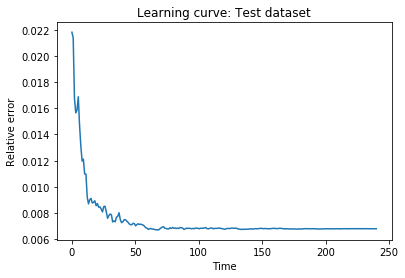

In [20]:
############ STEP 1.4.1 #############################################
save = False  # Should we save the following figs? 
filename_train = mySom.name + "_err_train"   # Names of the files of the saved figs
filename_test = mySom.name + "_err_test"

print_error(mySom.relerr_train,legend="Learning curve: Train dataset",save=save, path=path_fig, filename=filename_train)
print_error(mySom.relerr_test,legend="Learning curve: Test dataset",save=save, path=path_fig, filename=filename_test)

###### 1.4.2 Weights features

Here we will plot some features of the weights of the SOM and try to answer these questions:
- Are similar weights close to each other - resulting in specialized areas in the map - as they should in a SOM?
- Are some neurons redundant?

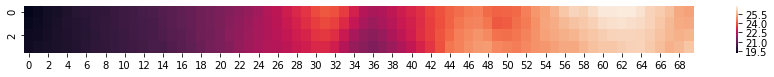

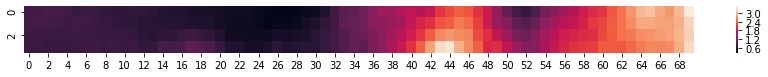

TEMPERATURE depth 26 - 20


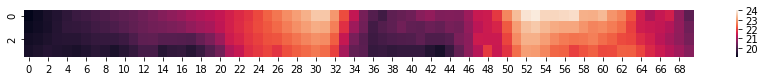

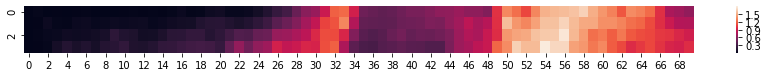

TEMPERATURE depth 20 - 13


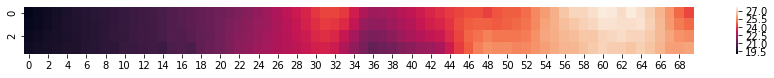

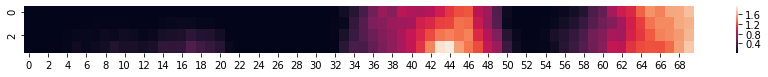

TEMPERATURE depth 13 - 7


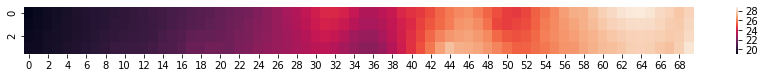

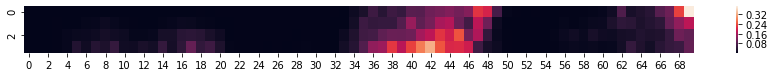

TEMPERATURE depth 7 - 0


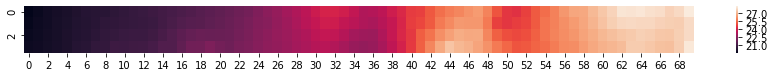

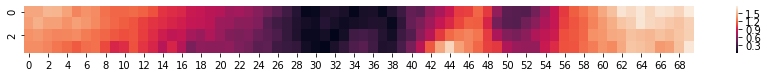

In [24]:
mySom.clear_map_info()

if not surface or p>1:
    # If we are using observable variable, each element of the vector represents a different type of data
    # and should be treated separately
    if surface:
        for i in range(nb_data_used):
            print("DATA TYPE : ", data_type[data_type_used[i]])
            weights_mean = mySom.weights_features(features="mean",start=i,end=i+1)
            mySom.print_heatmap(weights_mean)
    # If we are using hidden variable, each element of the vector represents a different level of depth 
    # of the temperature vertical profile and we can "merge" them to make the plotting easier to interpret 
    else:
        weights_mean = mySom.weights_features(features="mean")
        weights_dev = mySom.weights_features("std")
        mySom.print_heatmap(weights_mean)
        mySom.print_heatmap(weights_dev)
        parts = 4  # the whole profiles will be decomposed into 4 smaller profiles 
        for i in range(parts):
            start=i*p//parts
            end=(i+1)*p//parts
            print("TEMPERATURE depth", p-start, "-", p-end )
            weights_mean = mySom.weights_features(features="mean",start=start,end=end)
            mySom.print_heatmap(weights_mean)
            weights_std = mySom.weights_features(features="std",start=start,end=end)
            mySom.print_heatmap(weights_std)

###### 1.4.2 SOM outputs

Here are the outputs of our SOM for the complete dataset. The following plots should help to answer these questions:
- Is there a problem of overfitting/underfitting?
- Are outputs of the SOM representative of the inputs?
- Are some periods of year well represented while some others are poorly represented?
- Can the SOM represent well enough extreme inputs (very high/low temperature? High on the surface and low in the deep subsurface? 

74  inputs mapped in  0.25  sec


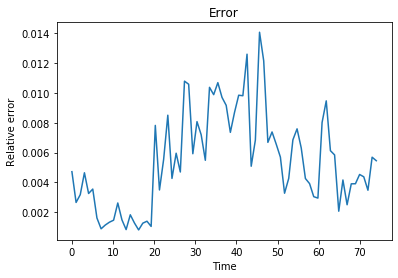

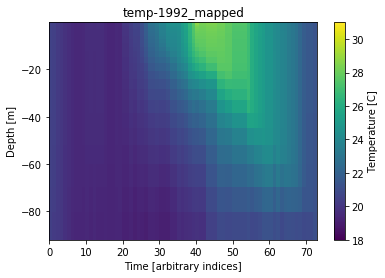

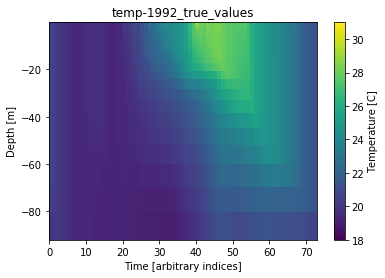

73  inputs mapped in  0.26  sec


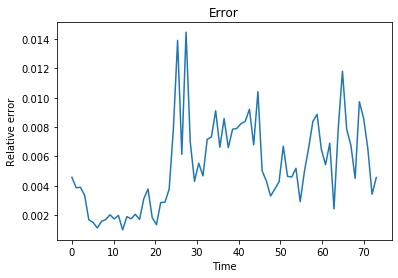

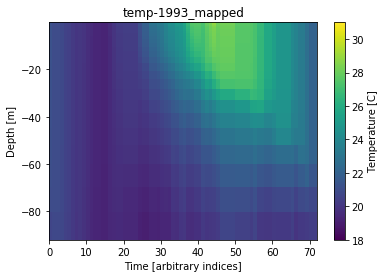

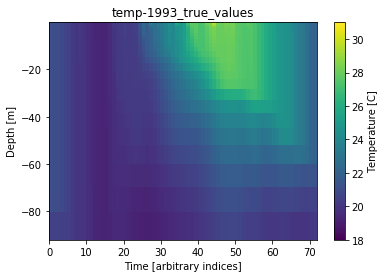

73  inputs mapped in  0.27  sec


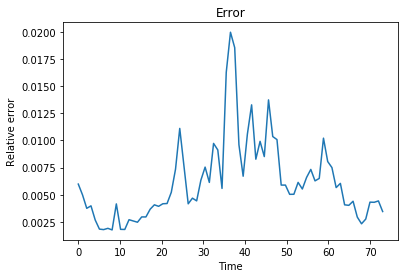

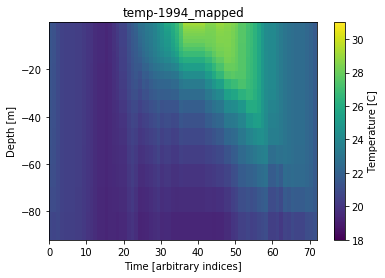

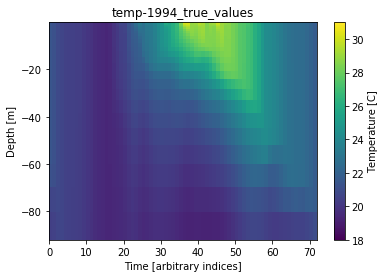

73  inputs mapped in  0.27  sec


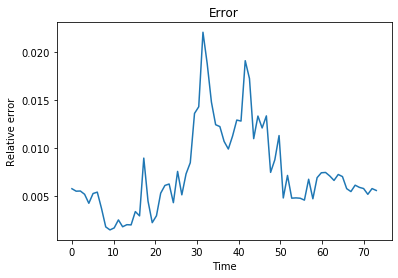

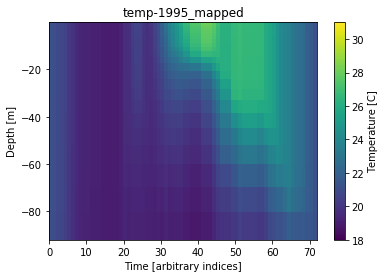

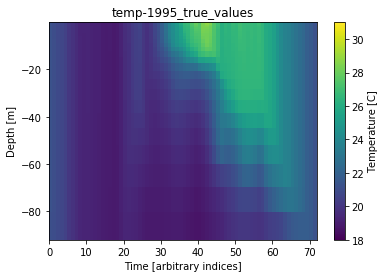

74  inputs mapped in  0.25  sec


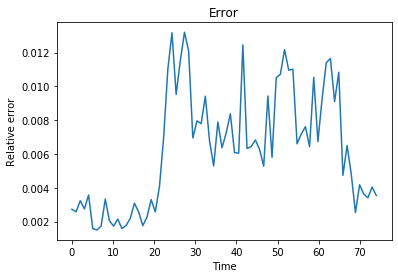

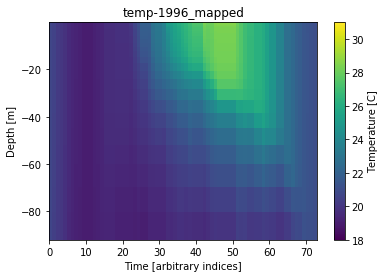

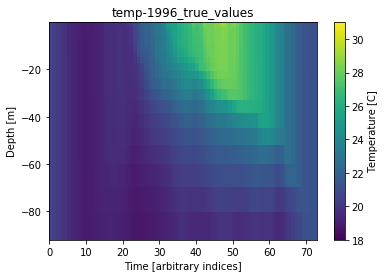

73  inputs mapped in  0.29  sec


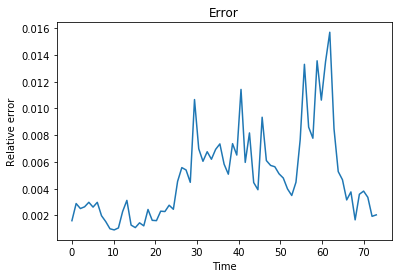

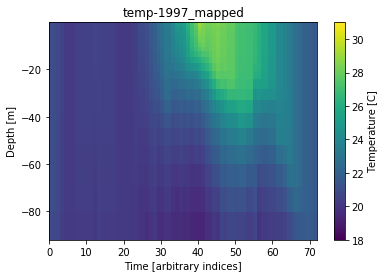

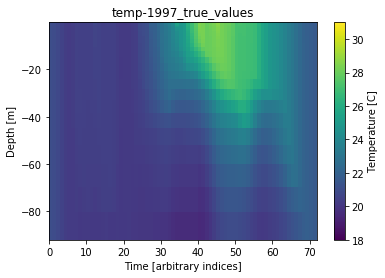

73  inputs mapped in  0.31  sec


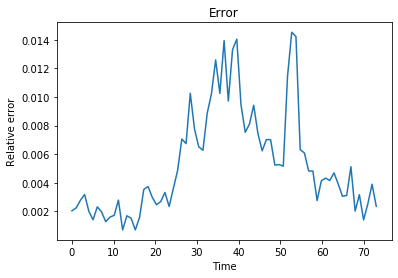

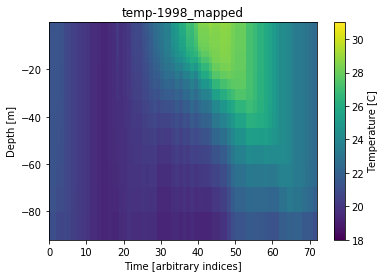

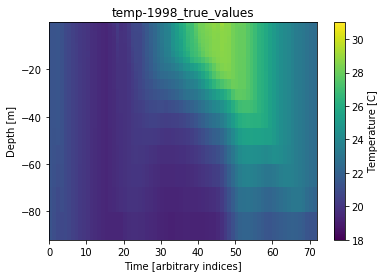

73  inputs mapped in  0.28  sec


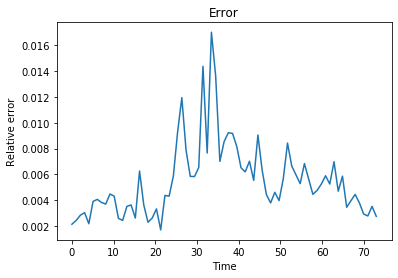

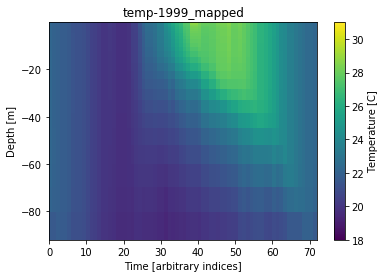

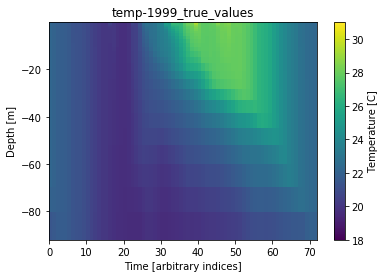

74  inputs mapped in  0.31  sec


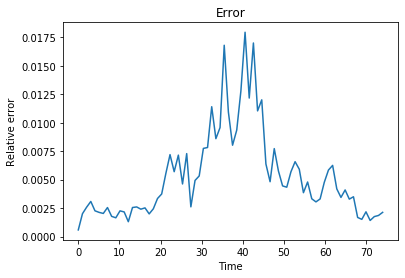

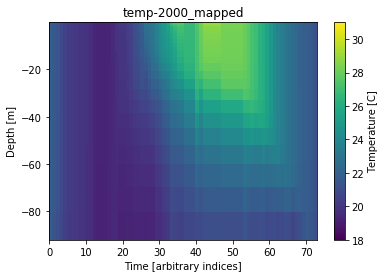

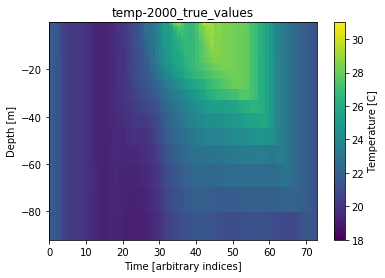

73  inputs mapped in  0.31  sec


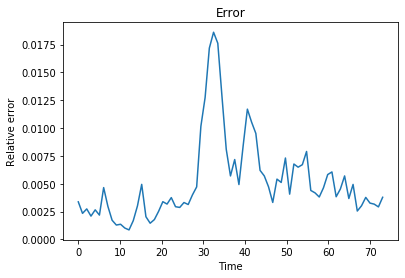

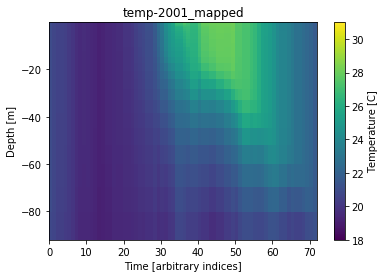

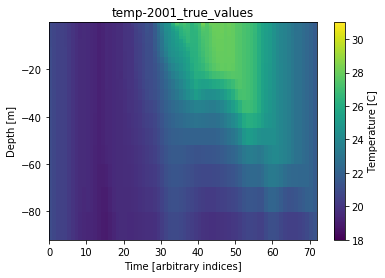

73  inputs mapped in  0.31  sec


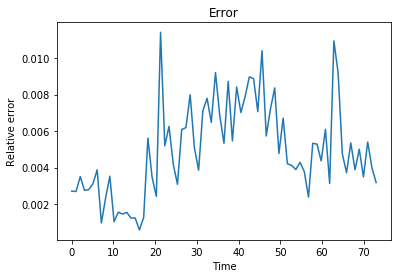

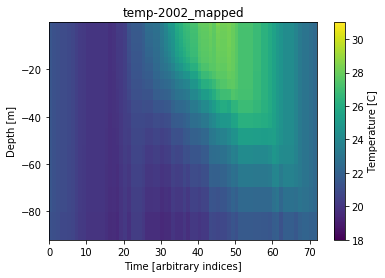

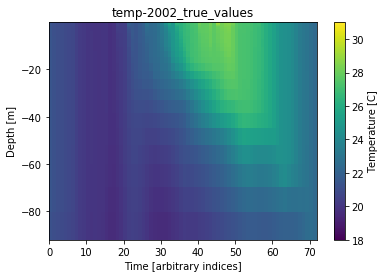

73  inputs mapped in  0.32  sec


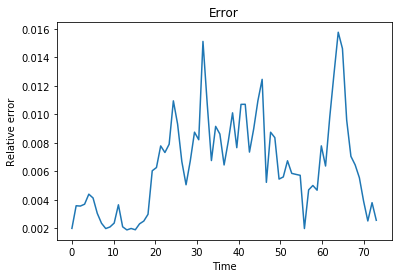

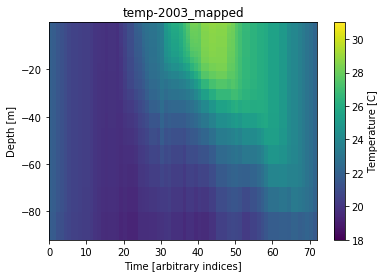

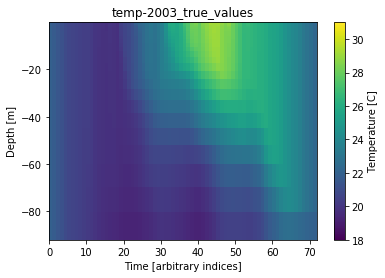

74  inputs mapped in  0.32  sec


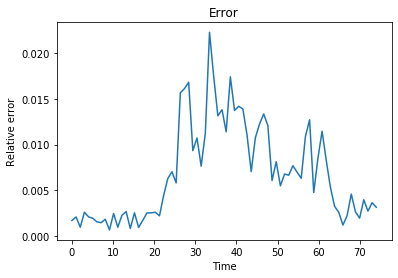

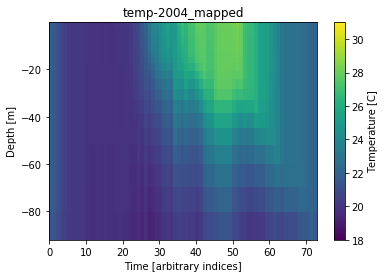

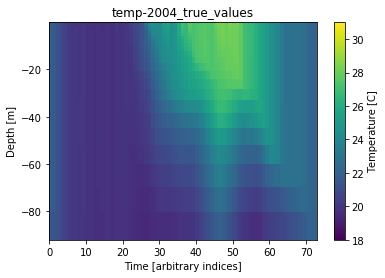

73  inputs mapped in  0.27  sec


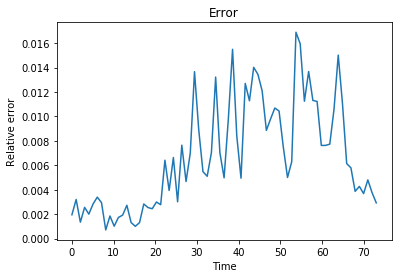

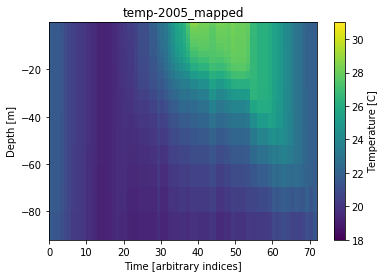

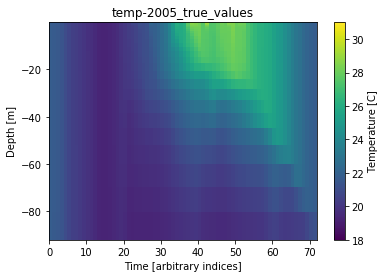

73  inputs mapped in  0.28  sec


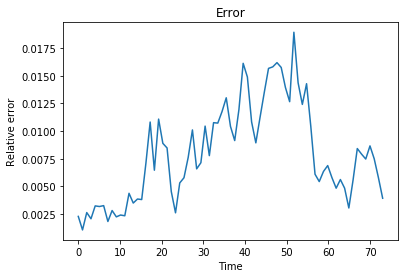

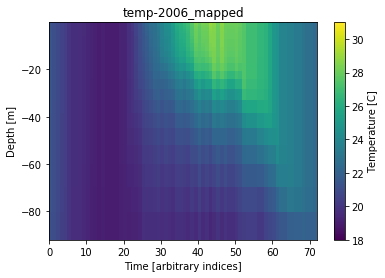

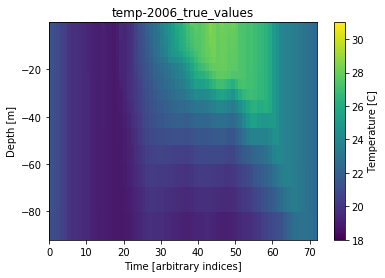

72  inputs mapped in  0.28  sec


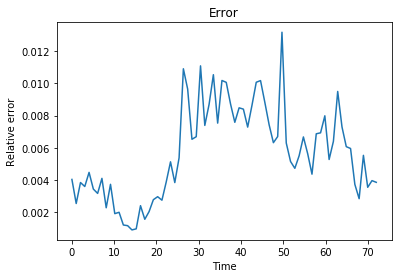

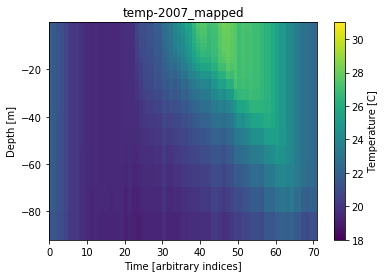

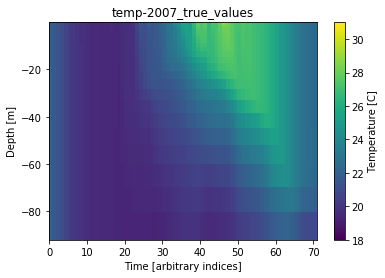

In [22]:
save=False

mySom.clear_map_info()
data = data_mapping_norm
for y in range(0,nb_years):
    inputs_array = data[y]
    name=str(1992+y)+"_mapped"
    # map the data with our trained SOM "mySom"
    myMap = map2d.Map2d(som=mySom, name=name)
    myMap.map_from_data(inputs_array,overwrite=True)
    name_err = name + "_err"
    # print the mapping error 
    print_error(myMap.relerr, save=save,path=path_fig,filename=name_err)
    if surface:
        # If we are using observable variable, each element of the vector represents a different type of data
        # and should be treated separately
        for i in range(nb_data_used):
            zmin=int(data_min[i])  
            zmax=int(data_max[i])+1
            
            # print SOM output
            legend=data_type[data_type_used[i]] + "-"+str(1992+y)+"_mapped"
            name_i = name+"_"+data_type[data_type_used[i]]
            print_data(myMap.values[:,i],legend=legend,
                       save=save, path=path_fig, filename=name_i ,zmin=zmin,zmax=zmax)
            
            # print the corresponding true values (SOM inputs)
            legend=data_type[data_type_used[i]] + "-"+str(1992+y)+"_true_values"
            print_data(destandardize(data[y][:,i],data_mean=data_mean[i], data_stdev=data_stdev[i]),
                       legend=legend, zmin=zmin,zmax=zmax)
    else:
        zmin=int(data_min[0])
        zmax=int(data_max[0])+1
        # print SOM output
        legend="temp-"+str(1992+y)+"_mapped"   
        print_data(myMap.values, depth, legend=legend,
                   save=save,path=path_fig, filename=name,zmin=zmin,zmax=zmax)
        # print the corresponding true values (SOM inputs)
        legend="temp-"+str(1992+y)+"_true_values"
        print_data(destandardize(data[y],data_mean=data_mean, data_stdev=data_stdev),
                   depth,legend=legend,zmin=zmin,zmax=zmax)        

879  inputs mapped in  0.67  sec
Number of classes that were NOT used to map the whole training dataset:  16


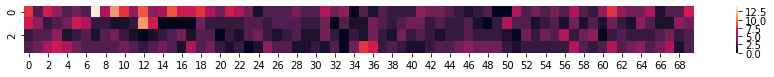

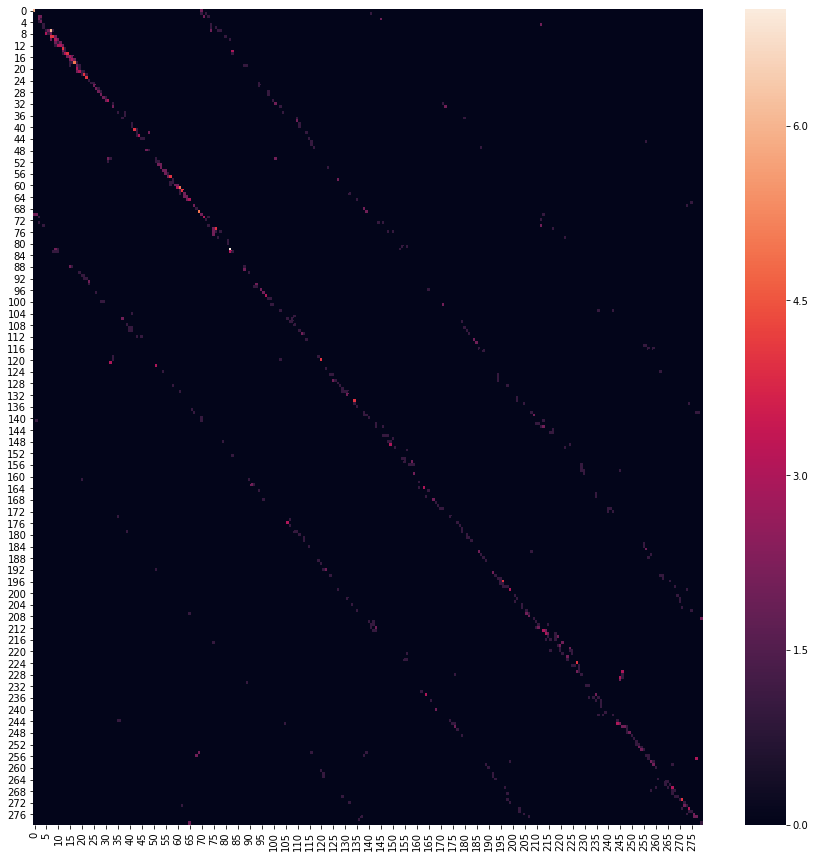

In [23]:
mySom.clear_map_info()
inputs_array = np.concatenate(data_mapping_norm[:nb_years_trained])
name="1992-"+str(1992+nb_years_trained-1)+"_mapped"
map_tot = map2d.Map2d(som=mySom,name=name)
map_tot.map_from_data(inputs_array)

count = np.count_nonzero(map_tot.som.occ_bmu_map)
print("Number of classes that were NOT used to map the whole training dataset: ", n*m-count)
res = mySom.print_heatmap(data=map_tot.som.occ_bmu_map)

# Heatmap of the transition matrix
fig= plt.figure(figsize=(15,15))
sns.heatmap(mySom.transition, annot=False)

**If you are satisfied with the results you can save your Som and Map2d objects! :)**

In [14]:
save=False
# Save the SOM with map_info generated only with the training dataset
som.save(mySom, path=path_som)

save=False
# Save a Map2d object for each year of the entire dataset
for y in range(nb_years):
    name=str(1992+y)+"_mapped"
    inputs_array = data[y]
    newMap = map2d.Map2d(som=som.copy(mySom),name=name)
    newMap.map_from_data(inputs_array)
    if save:
        map2d.save(newMap, path=path_map)

save = False
# Save the Map2d corresponding to the entire training dataset  
inputs_array = np.concatenate(data_mapping_norm[:nb_years_trained])
name="1992-"+str(1992+nb_years_trained-1)+"_mapped"
map_tot = map2d.Map2d(som=som.copy(mySom),name=name)
map_tot.map_from_data(inputs_array)
if save:
    map2d.save(map_tot, path=path_map)
    
save=False
# Save the Map2d corresponding to the entire testing dataset  
inputs_array = np.concatenate(data_mapping_norm[nb_years_trained:])
name=str(1992+nb_years_trained)+"-2007_mapped"
map_tot = map2d.Map2d(som=som.copy(mySom),name=name)
map_tot.map_from_data(inputs_array)
if save:
    map2d.save(map_tot, path=path_map)

74  inputs mapped in  0.08  sec
73  inputs mapped in  0.09  sec
73  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
74  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
74  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
73  inputs mapped in  0.08  sec
74  inputs mapped in  0.08  sec
73  inputs mapped in  0.09  sec
73  inputs mapped in  0.08  sec
72  inputs mapped in  0.09  sec
879  inputs mapped in  0.47  sec
292  inputs mapped in  0.18  sec
